In [166]:
import pandas
import seaborn as sns

# To analyze orbital dynamics effectively, we need these orbital and physical parameters:
identifier_params = [
    'full_name',  # Full designation
    'spkid',     # SPK ID
    'neo',        # Near-Earth Object flag
    'pha',        # Potentially Hazardous Asteroid flag
]

crucial_orbital_params = [
    'a',        # Semi-major axis (AU)
    'e',        # Eccentricity
    'i',        # Inclination (deg)
    'q',        # Perihelion distance (AU)
    'ad',       # Aphelion distance (AU)
    'per',      # Orbital period (years)
    'n',        # Mean motion (deg/day)
    'ma',       # Mean anomaly (deg)
]

physical_properties = [
    'H',        # Absolute magnitude (size proxy)
    'diameter', # Diameter (km) - when available
    'albedo',   # Geometric albedo
    'rot_per',  # Rotation period (hours)
    'GM',       # Mass parameter (rare but valuable)
    'spec_B',   # Spectral type (Bus/Tholen)
    'spec_T',   # Taxonomic class
]


# Non-essential data but useful for assessing data quality later down the line
quality_metrics = [
    'condition_code',  # Orbit uncertainty (0-9, 0=best)
    'n_obs_used',      # Number of observations
    'data_arc',        # Observation span (days)
    'first_obs',       # First observation date
    'last_obs',        # Last observation date
]


In [167]:
import requests

def query_jpl_sbdb(include_quality_metrics=False):
    base_url = "https://ssd-api.jpl.nasa.gov/sbdb_query.api"
    results = []
    fields_str = identifier_params + crucial_orbital_params + physical_properties + (quality_metrics if include_quality_metrics else [])
    print(','.join(fields_str))

    params = {
        'fields': ','.join(fields_str),
        'limit': 100  # Limit the number of results
    }
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        results.append(response.json())
    else:
        print(f"Error: {response.status_code} - {response.text}")
    
    return results


In [168]:
jpl_data = query_jpl_sbdb()


full_name,spkid,neo,pha,a,e,i,q,ad,per,n,ma,H,diameter,albedo,rot_per,GM,spec_B,spec_T


In [169]:
# pandas.DataFrame(jpl_data)
df = pandas.json_normalize(jpl_data, record_path=['data'])

# set column names from jpl_data[0]['fields'] if present
fields = jpl_data[0].get('fields') if isinstance(jpl_data, list) and jpl_data else None
if fields:
    if len(fields) == len(df.columns):
        df.columns = fields
    else:
        # align/truncate if lengths differ
        df.columns = fields[:len(df.columns)]
df.head()

,full_name,spkid,neo,pha,a,e,i,q,ad,per,n,ma,H,diameter,albedo,rot_per,GM,spec_B,spec_T
0,1 Ceres (A801 AA),20000001,N,N,2.766,0.0796,10.59,2.546,2.99,1.68e+03,0.2143,231.54,3.35,939.4,0.090,9.074170,62.6284,C,G
1,2 Pallas (A802 FA),20000002,N,N,2.77,0.2306,34.93,2.131,3.41,1.68e+03,0.2138,211.53,4.11,513,0.155,7.8132214,13.63,B,B
2,3 Juno (A804 RA),20000003,N,N,2.671,0.2558,12.99,1.988,3.35,1.59e+03,0.2258,217.59,5.19,246.596,0.214,7.21,None,Sk,S
3,4 Vesta (A807 FA),20000004,N,N,2.362,0.0902,7.14,2.149,2.57,1.33e+03,0.2716,26.81,3.25,522.77,0.4228,5.3421276322,17.2882844,V,V
4,5 Astraea (A845 XA),20000005,N,N,2.577,0.1875,5.36,2.094,3.06,1.51e+03,0.2383,133.87,6.97,106.699,0.274,16.806,None,S,S


In [170]:
# Now let's clean that data from Gaia (`tableb1.dat`)
# CSV headers converted from the fixed-width spec for tableb1.dat

csv_headers = [
    'Asteroid',   # Name of the asteroid
    'H',          # Absolute magnitude (mag)
    'RMS',        # RMS of normalized residuals, 7D OD
    'RMS6D',      # RMS of normalized residuals, 6D OD
    'A2',         # Transversal acceleration component (au/d2)
    'e_A2',       # Error in A2 (au/d2)
    'da_dt',      # Semi-major axis drift (au/Myr)
    'e_da_dt',    # Error in da/dt (au/Myr)
    'max_da_dt',  # Maximum da/dt from Monte Carlo model (au/Myr)
    'SNR',        # Signal-to-noise of A2 detection
    'FAccept',    # [1 Rej.] Flag for acceptance of the detection
    'NOptObs',    # Number of optical observations
    'NRejOpt',    # Number of rejected optical observations in 7D OD
    'NRej6D',     # Number of rejected optical observations in 6D OD
    'NRadObs',    # Number of radar observations
    'NRejRad',    # Number of rejected radar obs in 7D OD
    'NRejRad6D',  # Number of rejected radar obs in 6D OD
    'NOptOld',    # Number of old observations
    'Dlow',       # 15-th percentile of diameter (m)
    'Dmed',       # 50-th percentile of diameter (m)
    'Dhigh',      # 85-th percentile of diameter (m)
    'ModFlag',    # [0/1] Flag for model used in Monte Carlo
    'Prot',       # Rotation period of the asteroid (h), ?=-1 if unknown
    'Tax',        # Taxonomic complex of the asteroid
    'deltat'      # Length of observational arc (yr)
]


In [171]:
# Now let's load that data from Gaia (`tableb1.dat`)

# `names` must be a list of column names (use csv_headers), and explicitly set header=None

gaia_data = pandas.read_fwf(
	'./confirmed_yark_dataset/tableb1.dat',
	colspecs='infer',
)
gaia_data.columns = csv_headers
gaia_data.head()

gaia_data

,Asteroid,H,RMS,RMS6D,A2,e_A2,da_dt,e_da_dt,max_da_dt,SNR,...,NRejRad,NRejRad6D,NOptOld,Dlow,Dmed,Dhigh,ModFlag,Prot,Tax,deltat
0,1998 SD9,23.918,0.788754,6.841540,-2.898460e-13,1.564160e-15,-0.019706,0.000106,0.031790,185.30500,...,0,0,27,25.295,35.41,75.886,1,-1.00,N,19.992
1,99942,18.945,0.307869,0.336636,-2.888940e-14,2.350760e-16,-0.001326,0.000011,0.002811,122.89400,...,0,5,0,300.000,340.00,380.000,0,27.38,N,17.180
2,480883,20.900,0.472885,2.486020,-6.918980e-14,7.312950e-16,-0.005045,0.000053,0.011612,94.61270,...,0,2,0,103.673,172.78,287.979,1,-1.00,V,20.085
3,2340,20.437,0.728716,0.759563,-2.998710e-14,5.250600e-16,-0.001738,0.000030,0.008028,57.11180,...,0,0,92,134.014,193.57,312.700,1,3.35,Q,45.120
4,524522,20.530,0.463988,1.099570,-5.983760e-14,1.051020e-15,-0.003592,0.000063,0.004257,56.93290,...,0,7,0,112.383,176.60,337.150,1,13.43,N,16.060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,2005 NE21,21.268,0.587481,0.615949,5.852140e-14,1.938950e-14,0.003712,0.001230,0.008357,3.01820,...,0,0,0,102.221,147.65,261.232,1,-1.00,S,14.007
458,152664,19.669,0.478537,0.486609,1.623280e-14,5.381410e-15,0.000907,0.000301,0.004420,3.01645,...,0,0,40,225.018,353.59,739.343,1,17.38,Q,27.910
459,7336,18.789,0.464234,0.469641,3.145140e-14,1.043840e-14,0.001143,0.000379,0.002218,3.01305,...,0,0,203,273.707,430.11,742.918,1,3.36,Q,35.239
460,162416,21.330,0.585074,0.489558,1.559140e-11,5.182290e-12,0.630594,0.209598,0.006902,3.00859,...,0,0,0,116.000,141.00,166.000,0,-1.00,N,5.322


In [172]:
# Let's get clean names or IAU designations from the Gaia dataset
gaia_names = gaia_data['Asteroid'].tolist()

In [173]:
f = open("names", "w")
for name in gaia_names:
    f.write(name + "\n")
f.close()

In [157]:
# import requests
# import time
# import json

# def fetch_asteroid_data(designation):
#     """Fetches complete data for an asteroid, including physical parameters."""
#     url = "https://ssd-api.jpl.nasa.gov/sbdb.api"
#     params = {
#         'sstr': designation,
#         'phys-par': 1  # Essential to get physical properties
#     }
    
#     try:
#         response = requests.get(url, params=params)
#         response.raise_for_status()  # Raises an exception for bad status codes
#         return response.json()
#     except requests.exceptions.RequestException as e:
#         print(f"Error fetching data: {e}")
#         return None

# f = open("names", "r")
# read_list = f.readlines()
# f.close()

# for designation in read_list[329:]:
#     data = fetch_asteroid_data(designation)
#     print(json.dumps(data, indent=2))
#     time.sleep(1)  # Be polite to the API
#     if not data:
#         continue

#     # write the raw "object" JSON to file (one JSON object per line)
#     with open('asteroid_mapping.txt', 'a') as f:
#         f.write(json.dumps(data) + '\n')

    # print(f"Wrote raw object for {designation}: spkid={data.get('object').get('spkid')}, des={data.get('object').get('des')}")


In [158]:
f = open("asteroid_mapping.txt", "r")
asteroid_mapping_lines = f.readlines()
f.close()

In [159]:
import pandas as pd
import json

def extract_asteroid_data(json_data):
    """
    Extract specified parameters from JPL SBDB JSON data
    """
    extracted = {}
    
    # Identifier Parameters
    extracted['full_name'] = json_data.get('object', {}).get('fullname')
    extracted['spkid'] = json_data.get('object', {}).get('spkid')
    extracted['neo'] = json_data.get('object', {}).get('neo', False)
    extracted['pha'] = json_data.get('object', {}).get('pha', False)
    
    # Extract orbital elements from the elements list
    orbit_elements = {}
    if 'orbit' in json_data and 'elements' in json_data['orbit']:
        for element in json_data['orbit']['elements']:
            label = element.get('label')
            value = element.get('value')
            if label and value is not None:
                orbit_elements[label] = value
    
    # Crucial Orbital Parameters
    extracted['a'] = orbit_elements.get('a')  # semi-major axis
    extracted['e'] = orbit_elements.get('e')  # eccentricity
    extracted['i'] = orbit_elements.get('i')  # inclination
    extracted['q'] = orbit_elements.get('q')  # perihelion distance
    extracted['ad'] = orbit_elements.get('Q')  # aphelion distance (note: 'Q' not 'ad')
    extracted['per'] = orbit_elements.get('period')  # orbital period
    extracted['n'] = orbit_elements.get('n')  # mean motion
    extracted['ma'] = orbit_elements.get('M')  # mean anomaly (note: 'M' not 'ma')
    
    # Extract physical parameters from phys_par list
    phys_params = {}
    if 'phys_par' in json_data:
        for param in json_data['phys_par']:
            name = param.get('name')
            value = param.get('value')
            if name and value is not None:
                phys_params[name] = value
    
    # Physical Properties
    extracted['H'] = phys_params.get('H')  # absolute magnitude
    extracted['diameter'] = phys_params.get('diameter')  # diameter in km
    extracted['albedo'] = phys_params.get('albedo')  # geometric albedo
    extracted['rot_per'] = phys_params.get('rot_per')  # rotation period
    extracted['GM'] = phys_params.get('GM')  # mass parameter
    
    # Spectral types (these are typically in the object section)
    extracted['spec_B'] = json_data.get('object', {}).get('spec_B')
    extracted['spec_T'] = json_data.get('object', {}).get('spec_T')
    
    return extracted

def clean_asteroid_data(json_list):
    """
    Clean and convert a list of asteroid JSON objects to a DataFrame
    """
    cleaned_data = []
    
    for json_obj in json_list:
        try:
            extracted = extract_asteroid_data(json_obj)
            cleaned_data.append(extracted)
        except Exception as e:
            print(f"Error processing asteroid data: {e}")
            continue
    
    # Create DataFrame
    df = pd.DataFrame(cleaned_data)
    
    # Convert data types
    numeric_columns = ['a', 'e', 'i', 'q', 'ad', 'per', 'n', 'ma', 'H', 'diameter', 'albedo', 'rot_per', 'GM']
    
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Convert boolean columns
    bool_columns = ['neo', 'pha']
    for col in bool_columns:
        if col in df.columns:
            df[col] = df[col].astype(bool)
    
    return df

# Alternative function for processing from a file
def process_asteroid_file(filename):
    """
    Process asteroid data from a JSON file
    """
    try:
        with open(filename, 'r') as f:
            if filename.endswith('.json'):
                # Single JSON object or array
                data = json.load(f)
            else:
                # JSONL format (one JSON per line)
                data = [json.loads(line) for line in f]
        
        return clean_asteroid_data(data)
    except Exception as e:
        print(f"Error reading file: {e}")
        return pd.DataFrame()

    
# Clean the data
cleaned_asteroid_df = process_asteroid_file('asteroid_mapping.txt')

print("Cleaned DataFrame:")
print(cleaned_asteroid_df.head())
print(f"\nDataFrame shape: {cleaned_asteroid_df.shape}")
print(f"\nColumns: {list(cleaned_asteroid_df.columns)}")
print(f"\nData types:\n{cleaned_asteroid_df.dtypes}")

# Optional: Save to CSV for your ML model
cleaned_asteroid_df.to_csv('cleaned_asteroid_data.csv', index=False)
print("\nData saved to 'cleaned_asteroid_data.csv'")

Cleaned DataFrame:
                   full_name     spkid   neo    pha      a      e     i  \
0                 (1998 SD9)   3014184  True  False  0.702  0.504  2.99   
1   99942 Apophis (2004 MN4)  20099942  True   True  0.922  0.191  3.34   
2          480883 (2001 YE4)  20480883  True   True  0.677  0.540  4.85   
3      2340 Hathor (1976 UA)  20002340  True   True  0.844  0.450  5.86   
4  524522 Zoozve (2002 VE68)  20524522  True   True  0.724  0.410  9.04   

       q    ad    per     n     ma      H  diameter  albedo  rot_per  GM  \
0  0.348  1.06  215.0  1.67  233.0  24.09       NaN     NaN      NaN NaN   
1  0.746  1.10  324.0  1.11  313.0  19.09      0.34    0.35    30.56 NaN   
2  0.311  1.04  203.0  1.77  193.0  20.92       NaN     NaN      NaN NaN   
3  0.464  1.22  283.0  1.27  202.0  20.43      0.30     NaN     3.35 NaN   
4  0.427  1.02  225.0  1.60  329.0  20.54       NaN     NaN    13.50 NaN   

  spec_B spec_T  
0   None   None  
1   None   None  
2   None   None  
3

In [248]:
cleaned_gaia_data = gaia_data[['Asteroid', 'da_dt', 'e_da_dt', 'A2', 'SNR', 'FAccept', 'Tax', 'deltat']]
cleaned_gaia_data.rename(columns={'Asteroid': 'full_name'}, inplace=True)

/tmp/ipykernel_264470/3723817240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_gaia_data.rename(columns={'Asteroid': 'full_name'}, inplace=True)


In [249]:
pd.concat([cleaned_asteroid_df, cleaned_gaia_data], axis=1).to_csv('combined_asteroid_gaia.csv', index=False)

In [250]:
import seaborn as sns
import matplotlib.pyplot as plt

combined_df = pd.read_csv("combined_asteroid_gaia.csv")

combined_df.drop_duplicates(subset=['full_name'], keep='first', inplace=True)  # drop duplicate full_name entries, keep first occurrence
combined_df.dropna(axis=0, subset=['spkid', 'da_dt'], inplace=True)  # drop rows where da_dt is null and spkid is null

# Drop unnecessary columns from the combining process
combined_df.drop(columns=['spec_B', 'spec_T', 'full_name.1'], inplace=True)
combined_df.drop(columns=['GM'], inplace=True)  # GM only has 2 non-null values, might as well drop it

combined_df.replace({"FAccept": {1: 1, "Rej.": 0}}, inplace=True)
combined_df = combined_df.astype({'FAccept': 'int32'})
combined_df.replace({"neo": {True: 1, False: 0}}, inplace=True)
combined_df.replace({"pha": {True: 1, False: 0}}, inplace=True)

# combined_df.head(30)
# sns.pairplot(combined_df.drop(columns=['spkid']))

/tmp/ipykernel_264470/1204198184.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df.replace({"neo": {True: 1, False: 0}}, inplace=True)
/tmp/ipykernel_264470/1204198184.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df.replace({"pha": {True: 1, False: 0}}, inplace=True)


=== Basic info ===
Rows: 459
Columns: ['full_name', 'spkid', 'neo', 'pha', 'a', 'e', 'i', 'q', 'ad', 'per', 'n', 'ma', 'H', 'diameter', 'albedo', 'rot_per', 'da_dt', 'e_da_dt', 'A2', 'SNR', 'FAccept', 'Tax', 'deltat']

=== Column dtypes ===
full_name     object
spkid        float64
neo            int64
pha            int64
a            float64
e            float64
i            float64
q            float64
ad           float64
per          float64
n            float64
ma           float64
H            float64
diameter     float64
albedo       float64
rot_per      float64
da_dt        float64
e_da_dt      float64
A2           float64
SNR          float64
FAccept        int32
Tax           object
deltat       float64
dtype: object

=== Missingness (%) ===
albedo       80.61
diameter     79.30
rot_per      62.53
pha           0.00
full_name     0.00
spkid         0.00
neo           0.00
i             0.00
e             0.00
a             0.00
q             0.00
n             0.00
per      

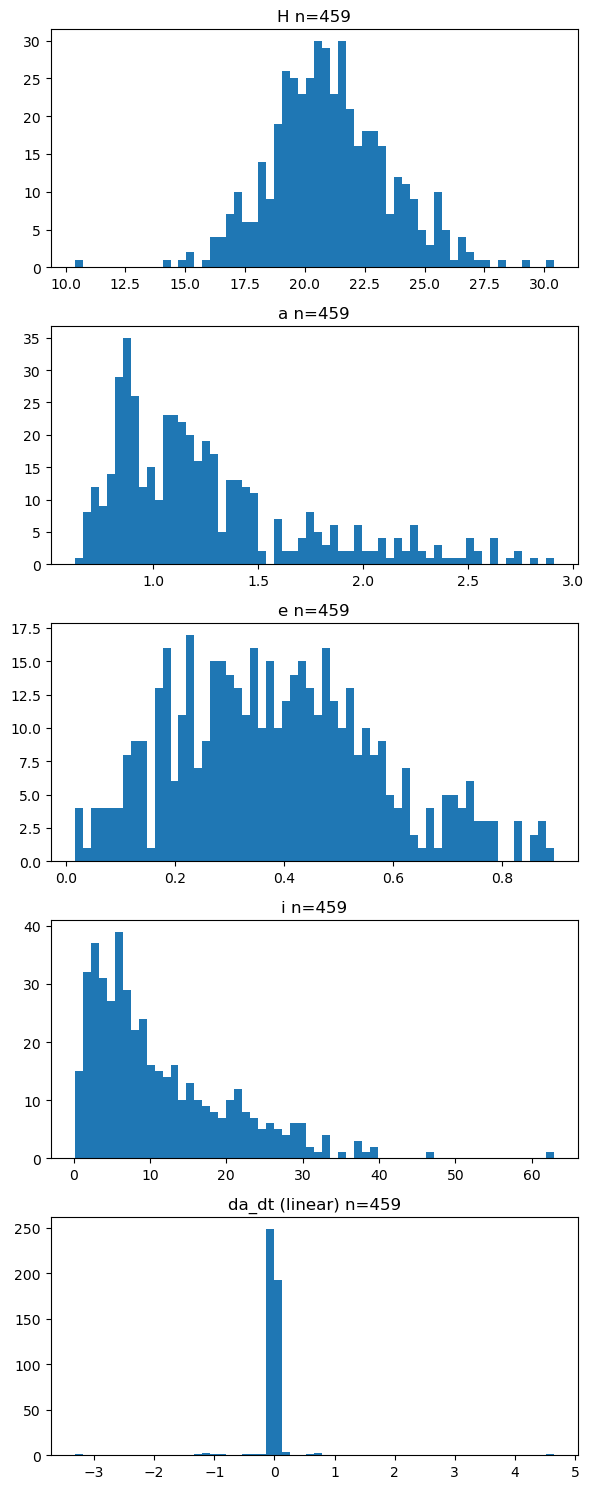

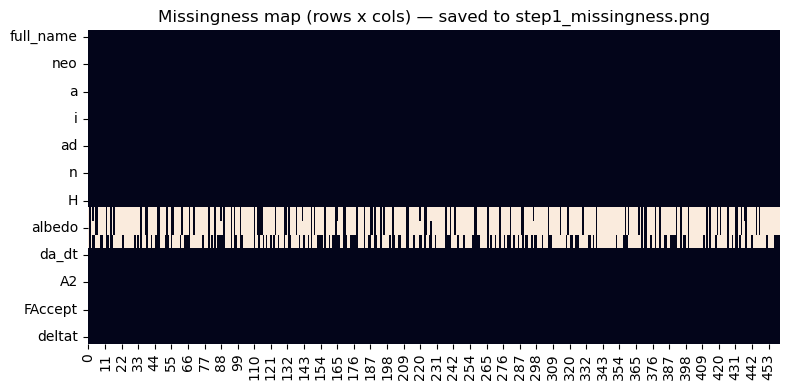

In [251]:
# Save as step1_inspect.py and run, or paste into a notebook cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys


df = combined_df

print("=== Basic info ===")
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
print("\n=== Column dtypes ===")
print(df.dtypes)

required = ['da_dt','H','a','e','i']
missing_required = [c for c in required if c not in df.columns]
if missing_required:
    print("\nERROR: Missing required columns:", missing_required)
    sys.exit(1)

# Convert common numeric columns to numeric coercing errors so bad strings are caught
numcols = ['da_dt','H','a','e','i','albedo','rotation_period']
for c in numcols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Show missingness
print("\n=== Missingness (%) ===")
missing_pct = df.isna().mean() * 100
print(missing_pct.sort_values(ascending=False).round(2))

# Show how many rows have target
print("\nRows with da_dt:", (~df['da_dt'].isna()).sum(), " / ", len(df))

# Inspect the crucial 3 variables we will heavily use (H, albedo, diameter later)
print("\nH stats:")
print(df['H'].describe())

if 'albedo' in df.columns:
    print("\nalbedo stats:")
    print(df['albedo'].describe())

# Quick derived diameter if albedo present (for eyeballing)
if 'albedo' in df.columns and df['albedo'].notna().sum() > 0:
    D = 1329.0 / np.sqrt(df.loc[df['albedo'].notna(), 'albedo']) * 10**(-df.loc[df['albedo'].notna(), 'H']/5.0)
    print("\nDerived diameter stats (km) for rows with albedo:")
    print(D.describe())

# Quick histograms for H, a, e, i, da_dt (log-scale for da_dt if very small)
cols_to_plot = ['H','a','e','i','da_dt']
present = [c for c in cols_to_plot if c in df.columns]
n = len(present)
fig, axes = plt.subplots(n, 1, figsize=(6, 3*n))
for ax, c in zip(axes, present):
    series = df[c].dropna()
    if c == 'da_dt':
        # show linear + log insets for tiny values
        ax.hist(series, bins=60)
        ax.set_title(f"{c} (linear) n={len(series)}")
    else:
        ax.hist(series, bins=60)
        ax.set_title(f"{c} n={len(series)}")
plt.tight_layout()
plt.savefig("step1_histograms.png")
print("\nSaved histograms to step1_histograms.png")

# Show correlation of target with numeric features (simple)
print("\n=== Correlation with da_dt (pearson) ===")
numdf = df.select_dtypes(include=[np.number])
if 'da_dt' in numdf.columns:
    corr = numdf.corr()['da_dt'].drop('da_dt').sort_values(key=lambda s: s.abs(), ascending=False)
    print(corr.head(15).round(4))
else:
    print("No numeric da_dt present to compute correlations.")

# Missingness heatmap (visual)
plt.figure(figsize=(8,4))
sns.heatmap(df.isna().astype(int).T, cbar=False)
plt.title("Missingness map (rows x cols) — saved to step1_missingness.png")
plt.tight_layout()
plt.savefig("step1_missingness.png")
print("Saved missingness map to step1_missingness.png")

# Print a few problem rows: where H present but albedo missing, etc.
print("\nSample rows with H present and albedo missing (up to 10):")
sel = df[df['H'].notna() & df.get('albedo', pd.Series(dtype=float)).isna()]
print(sel.head(10)[['H','Tax','albedo']])


In [252]:
import numpy as np

df = df.copy()

# --- 1. Define taxonomy groups ---
dark_classes = ['C','Ch','Cg','Cgh','Cb','B','F','G','D','T','P']
bright_classes = ['S','Sq','Sr','Sv','Sk','Sa','Q','V']
moderate_classes = ['X','Xc','Xk','Xe','M','E']  # X is mixed, treat moderate

def classify_tax(t):
    if pd.isna(t):
        return 'unknown'
    t = str(t).strip().upper()
    if t in [x.upper() for x in dark_classes]:
        return 'dark'
    if t in [x.upper() for x in bright_classes]:
        return 'bright'
    if t in [x.upper() for x in moderate_classes]:
        return 'moderate'
    return 'unknown'

df['tax_group'] = df['Tax'].apply(classify_tax)

# --- 2. Assign albedo priors (expected values) ---
# Values are medians reflecting log-normal distributions
albedo_priors = {
    'dark': 0.06,
    'moderate': 0.11,
    'bright': 0.25,
    'unknown': 0.14  # population mixture
}

df['albedo_filled'] = df['tax_group'].map(albedo_priors)

# If actual albedo is present, use it instead:
if 'albedo' in df.columns:
    df['albedo_filled'] = df['albedo'].fillna(df['albedo_filled'])

# --- 3. Compute Diameter (km) from H and albedo ---
df['diameter_km'] = 1329 / np.sqrt(df['albedo_filled']) * 10**(-df['H']/5)

print(df[['H','Tax','tax_group','albedo_filled','diameter_km']].head(12))
print("\nDone: diameter_km and albedo_filled created.")


        H Tax tax_group  albedo_filled  diameter_km
0   24.09   N   unknown          0.140     0.054008
1   19.09   N   unknown          0.350     0.341579
2   20.92   V    bright          0.250     0.174002
3   20.43   Q    bright          0.250     0.218049
4   20.54   N   unknown          0.140     0.276988
5   22.62   N   unknown          0.100     0.125755
6   20.67   N   unknown          0.023     0.643667
7   19.64   N   unknown          0.140     0.419238
8   23.43   N   unknown          0.140     0.073192
9   23.77   N   unknown          0.140     0.062584
10  28.10   N   unknown          0.140     0.008520
11  20.64   N   unknown          0.140     0.264521

Done: diameter_km and albedo_filled created.


In [253]:
df = df.copy()

# Basic unit fix: convert i degrees → radians
df['i_rad'] = np.deg2rad(df['i'])

# Diameter transforms
df['logD'] = np.log(df['diameter_km'])
df['invD'] = 1.0 / df['diameter_km']

# Thermal forcing scaling term
df['thermal_scale'] = 1.0 / (df['a'] * (1 - df['e']**2))

# Keep only rows that actually have da_dt to train on:
train = df[df['da_dt'].notna()].copy()

print(train[['da_dt','H','a','e','i_rad','logD','invD','thermal_scale']].head(10))
print("\nTraining rows:", len(train))


      da_dt      H      a      e     i_rad      logD       invD  thermal_scale
0 -0.019706  24.09  0.702  0.504  0.052185 -2.918616  18.515653       1.909560
1 -0.001326  19.09  0.922  0.191  0.058294 -1.074177   2.927582       1.125664
2 -0.005045  20.92  0.677  0.540  0.084648 -1.748687   5.747051       2.085128
3 -0.001738  20.43  0.844  0.450  0.102276 -1.523033   4.586116       1.485685
4 -0.003592  20.54  0.724  0.410  0.157778 -1.283781   3.610265       1.660314
5  0.007190  22.62  1.070  0.222  0.110130 -2.073420   7.951975       0.983027
6 -0.814757  20.67  2.230  0.858  0.055676 -0.440574   1.553599       1.699656
7  0.082924  19.64  2.910  0.606  0.191986 -0.869316   2.385278       0.543082
8 -0.016061  23.43  0.896  0.496  0.202458 -2.614675  13.662779       1.480232
9 -0.008006  23.77  0.763  0.386  0.363028 -2.771251  15.978611       1.540082

Training rows: 459


In [254]:
train = train.copy()

# Step 4a — Identify obviously impossible drift rates
mask_phys = train['da_dt'].abs() < 0.01

print("Rows before:", len(train))
print("Rows with |da_dt| < 0.01:", mask_phys.sum())
print("Removed:", (~mask_phys).sum())

# Keep only physically plausible da/dt rows
train = train[mask_phys].copy()

# Step 4b — (Important) Scale the target to improve ML learning
# Convert from au/Myr to micro-au/Myr range
# If your da_dt is already ~10^-4 — this will make values ~0.1 scale
train['da_dt_scaled'] = train['da_dt'] * 1e6

print("\nScaled da_dt summary:")
print(train['da_dt_scaled'].describe())


Rows before: 459
Rows with |da_dt| < 0.01: 357
Removed: 102

Scaled da_dt summary:
count     357.000000
mean    -1785.014474
std      3946.878123
min     -9952.810000
25%     -4154.580000
50%     -2033.500000
75%       738.005000
max      9923.090000
Name: da_dt_scaled, dtype: float64


In [255]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

features = ['H', 'a', 'e', 'i_rad', 'logD', 'invD', 'thermal_scale']

X = train[features]
y = train['da_dt_scaled']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42
)

model = XGBRegressor(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=600,
    subsample=0.7,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

model.fit(X_train, y_train)

pred = model.predict(X_val)

print("MAE:", mean_absolute_error(y_val, pred))
print("R^2:", r2_score(y_val, pred))


MAE: 2973.437536400265
R^2: -0.33145936031137513


In [256]:
# The R^2 look slike probably due to the signed nature of da/dt
# Let's create a magnitude column for da/dt, then we can guess the sign later
df['da_dt_mag'] = df['da_dt'].abs()
df['log_da_dt_mag'] = np.log10(df['da_dt_mag'])

In [257]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

features = ['H','a','e','i_rad','logD','invD','thermal_scale']
X = df[features]
y = df['log_da_dt_mag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("R²:", r2_score(y_test, pred))


MAE: 0.4710305033638323
R²: -0.022313876237225028


In [258]:
import numpy as np

pv_map = {
    'C': (0.05, 0.25),
    'B': (0.05, 0.25),
    'G': (0.05, 0.25),
    'F': (0.05, 0.25),

    'S': (0.23, 0.20),
    'Q': (0.23, 0.20),
    'K': (0.23, 0.20),
    'L': (0.23, 0.20),

    'V': (0.30, 0.18),

    'D': (0.04, 0.30),
    'P': (0.04, 0.30),

    'X': (0.12, 0.35)
}

def estimate_pv(row):
    t = row['Tax']
    if pd.notnull(row['albedo']):
        return row['albedo']
    if t in pv_map:
        median, spread = pv_map[t]
        # Draw a plausible albedo value instead of using a flat mean:
        return np.random.lognormal(mean=np.log(median), sigma=spread)
    return 0.10  # fallback if taxonomy unknown

df['albedo_est'] = df.apply(estimate_pv, axis=1)


In [259]:
df['D_km'] = 1329 * 10**(-df['H']/5) / np.sqrt(df['albedo_est'])
df['logD'] = np.log10(df['D_km'])
df['invD'] = 1 / df['D_km']


In [260]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

features = ['H','a','e','i_rad','logD','invD','thermal_scale']
X = df[features]
y = df['log_da_dt_mag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("R²:", r2_score(y_test, pred))


MAE: 0.4737925215075111
R²: -0.03529271515182564


In [261]:
# Maybe there are faulty data points skewing the results?
# Let's look at da_dt errors

df = df.copy()

# Convert the arc length from years to days
df['arc_length_days'] = df['deltat'] * 365.25

# Compute signal-to-noise of da/dt
df['da_dt_sig'] = df['da_dt'].abs() / df['e_da_dt']

# Filter for physically reliable drifts
good = (df['da_dt_sig'] > 3) & (df['arc_length_days'] > 3000)
df_good = df[good].copy()

print("Total rows:", len(df))
print("Rows with good Yarkovsky detections:", len(df_good))
print(f"Fraction kept: {len(df_good)/len(df):.2%}")

# Quick sanity check
print(df_good[['full_name','da_dt','e_da_dt','da_dt_sig','arc_length_days']].head())


Total rows: 459
Rows with good Yarkovsky detections: 418
Fraction kept: 91.07%
                   full_name     da_dt   e_da_dt   da_dt_sig  arc_length_days
0                 (1998 SD9) -0.019706  0.000106  185.305236       7302.07800
1   99942 Apophis (2004 MN4) -0.001326  0.000011  122.893186       6274.99500
2          480883 (2001 YE4) -0.005045  0.000053   94.612619       7336.04625
3      2340 Hathor (1976 UA) -0.001738  0.000030   57.111641      16480.08000
4  524522 Zoozve (2002 VE68) -0.003592  0.000063   56.932961       5865.91500


In [262]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Features (same as before)
features = ['H', 'a', 'e', 'i_rad', 'logD', 'invD', 'thermal_scale']
target = 'da_dt'   # use the signed da/dt again, not log-magnitude

X = df_good[features]
y = df_good[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=600,
    subsample=0.7,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

model.fit(X_train, y_train)

pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, pred))
print("R²:", r2_score(y_test, pred))


MAE: 0.030408595960152378
R²: -26.588422239854417


In [263]:
import numpy as np
import pandas as pd

# --- Solar GM in astronomical units & days (Gaussian gravitational constant) ---
k = 0.01720209895  # au^(3/2) / day
MU = k**2          # au^3 / day^2

AU = 1.0  # 1 au, for clarity

def mean_da_dt_from_A2(a, e, A2, scale_like_flux=True, n_steps=4000):
    """
    Compute orbit-averaged <da/dt> from transverse nongrav parameter A2.
    a: semimajor axis [au]
    e: eccentricity [0..1)
    A2: transverse accel parameter [au/day^2] (as in SBDB)
    scale_like_flux: if True, T = A2 * (AU/r)^2 ; if False, T = A2 (constant)
    returns: <da/dt> in au/day
    """
    a = float(a); e = float(e); A2 = float(A2)
    if not (0 <= e < 1):
        return np.nan

    p = a * (1 - e**2)                # semilatus rectum [au]
    h = np.sqrt(MU * a * (1 - e**2))  # specific angular momentum [au^2/day]

    # Gauss equation (radial R=0): da/dt = (2 a^2 / h) * (p/r) * T
    f = np.linspace(0, 2*np.pi, n_steps, endpoint=False)  # true anomaly
    r = p / (1 + e*np.cos(f))                             # radius [au]

    if scale_like_flux:
        T = A2 * (AU / r)**2
    else:
        T = np.full_like(r, A2)

    da_dt_inst = (2 * a**2 / h) * (p / r) * T            # au/day
    # Average over one orbit: <da/dt> = (1/P) ∫ (da/dt) dt ; dt = r^2/h df
    dt_df = r**2 / h
    orbit_avg = da_dt_inst * dt_df
    # Orbital period P:
    n = np.sqrt(MU / a**3)           # mean motion [rad/day]
    P = 2*np.pi / n                   # [day]

    mean_da_dt = orbit_avg.sum() * (2*np.pi / n_steps) / P  # au/day
    return mean_da_dt

def da_dt_from_A2_au_per_Myr(a, e, A2, scale_like_flux=True):
    val_day = mean_da_dt_from_A2(a, e, A2, scale_like_flux=scale_like_flux)
    return val_day * (365.25e6)  # convert au/day -> au/Myr

# ---- Apply to your dataframe ----
# Assumes columns: a (au), e, A2 (au/day^2)
# Produces: da_dt_from_A2 (au/Myr) using the (1/r^2) scaling
df_good = df_good.copy()
df_good['da_dt_from_A2'] = df_good.apply(
    lambda row: da_dt_from_A2_au_per_Myr(row['a'], row['e'], row['A2'], scale_like_flux=True),
    axis=1
)

# If you want to compare the two conventions:
df_good['da_dt_from_A2_constT'] = df_good.apply(
    lambda row: da_dt_from_A2_au_per_Myr(row['a'], row['e'], row['A2'], scale_like_flux=False),
    axis=1
)


In [265]:
print(df_good[['da_dt','da_dt_from_A2','da_dt_from_A2_constT']].head(10))
print("Corr(|da/dt_from_A2|, 1/D):",
      np.corrcoef(np.abs(df_good['da_dt_from_A2']), df_good['invD'])[0,1])


      da_dt  da_dt_from_A2  da_dt_from_A2_constT
0 -0.019706      -0.019693             -0.006253
1 -0.001326      -0.001326             -0.001066
2 -0.005045      -0.005041             -0.001378
3 -0.001738      -0.001738             -0.000882
4 -0.003592      -0.003590             -0.001428
5  0.007190       0.007202              0.007644
6 -0.814757      -0.831338             -0.560259
7  0.082924       0.083431              0.355612
8 -0.016061      -0.016068             -0.008446
9 -0.008006      -0.008004             -0.003658
Corr(|da/dt_from_A2|, 1/D): 0.011395053206092578


In [ ]:
# Let's try this again

import numpy as np

df = df_good.copy()

# Target: log10 of absolute da/dt from A2
df['log_da_dt_mag'] = np.log10(np.abs(df['da_dt_from_A2']))

# Features that matter most
features = ['logD', 'invD', 'a', 'e', 'thermal_scale']
X = df[features].values
y = df['log_da_dt_mag'].values


In [267]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=6,
    random_state=42,
)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
print("MAE (dex):", mean_absolute_error(y_test, pred))
print("R²:", r2_score(y_test, pred))


MAE (dex): 0.39486135513224035
R²: 0.024210586006564228


In [276]:
def predict_da_dt(H, a, e, Tax="unknown", D_km=None, model=rf, return_sign=True):
    pv_priors = {"C":0.06,"S":0.23,"V":0.30,"D":0.04,"X":0.12,"unknown":0.14}
    if D_km is None:
        pv = pv_priors.get(Tax.upper(), 0.14)
        D_km = 1329/np.sqrt(pv)*10**(-H/5)

    logD = np.log10(D_km)
    invD = 1.0 / D_km
    thermal_scale = 1/(a*(1-e**2))
    X_pred = np.array([[logD, invD, a, e, thermal_scale]])
    logmag = model.predict(X_pred)[0]
    mag = 10**logmag
    sign = -1 if Tax.upper() in ['C','B','D','P'] else 1
    return sign*mag


In [277]:
import numpy as np

def predict_da_dt_uncertainty(H, a, e, Tax='unknown', n_samples=500, model=rf):
    """
    Monte Carlo Yarkovsky drift estimate with physical uncertainties.
    
    Returns a dictionary:
        {'mean': value, 'std': sigma, 'samples': array, 'tax_prior': (pv_mu, pv_sigma)}
    """

    # --- taxonomy-based albedo & density priors ---
    pv_priors = {
        "C": (0.06, 0.25),
        "S": (0.23, 0.20),
        "V": (0.30, 0.18),
        "D": (0.04, 0.30),
        "X": (0.12, 0.35),
        "unknown": (0.14, 0.30),
    }
    rho_priors = {
        "C": (1.5, 0.3),
        "S": (2.7, 0.4),
        "V": (3.2, 0.4),
        "D": (1.2, 0.3),
        "X": (2.5, 0.6),
        "unknown": (2.0, 0.6),
    }

    t = Tax.upper()
    pv_mu, pv_sig = pv_priors.get(t, pv_priors['unknown'])
    rho_mu, rho_sig = rho_priors.get(t, rho_priors['unknown'])

    # --- Monte Carlo samples ---
    pv_samples = np.random.lognormal(mean=np.log(pv_mu), sigma=pv_sig, size=n_samples)
    rho_samples = np.random.normal(loc=rho_mu, scale=rho_sig, size=n_samples)
    rho_samples = np.clip(rho_samples, 0.5, 5.0)

    # --- compute derived features for each sample ---
    D = 1329 / np.sqrt(pv_samples) * 10 ** (-H / 5)
    logD = np.log10(D)
    invD = 1 / D
    thermal_scale = 1 / (a * (1 - e**2))

    Xs = np.column_stack((logD, invD, np.full(n_samples, a),
                          np.full(n_samples, e),
                          np.full(n_samples, thermal_scale)))

    # --- predict log-magnitude and back-transform ---
    logmag_pred = model.predict(Xs)
    mag_pred = 10 ** logmag_pred

    # --- assign sign statistically by taxonomy ---
    retro = ['C','B','D','P']
    sign = -1 if Tax.upper() in retro else 1
    signed_samples = sign * mag_pred

    return {
        'mean': float(np.mean(signed_samples)),
        'std': float(np.std(signed_samples)),
        'samples': signed_samples,
        'tax_prior': (pv_mu, pv_sig)
    }


In [272]:
out = predict_da_dt_uncertainty(H=21.0, a=1.1, e=0.25, Tax='C', n_samples=1000)
print(f"Predicted da/dt = {out['mean']:.3e} ± {out['std']:.3e} au/Myr")


Predicted da/dt = -2.621e-03 ± 2.157e-04 au/Myr


In [ ]:
print("Bennu example:", predict_da_dt(H=20.21, a=1.126391025894812, e=0.2037450762416414, Tax="C", D_km=0.492))
# This is actually really close to the actual measured value of -19.0e-4 au/Myr!

Bennu example: -0.002286851636560314
Bennu example (uncertainty): -2.785e-03 ± 6.300e-04 au/Myr


In [280]:
import numpy as np

# 1) Build a tiny calibration set of trusted objects (H, a, e, Tax, D_km, true |da/dt|)
cal = [
    # H,    a,      e,     Tax,  D_km,   true_abs_da_dt (au/Myr)
    (20.73, 1.1264, 0.2037, 'C', 0.492,  1.90e-3),  # Bennu
    # add a couple more if you can (Apophis, Golevka, etc.)
]

# 2) Get model predictions (magnitude) for each
def predict_mag(H,a,e,Tax,D_km):
    # same features as your predict_da_dt, but return magnitude only
    logD = np.log10(D_km)
    invD = 1.0 / D_km
    thermal_scale = 1.0 / (a*(1 - e**2))
    X_pred = np.array([[logD, invD, a, e, thermal_scale]])
    return 10**rf.predict(X_pred)[0]

y_true = []
y_pred = []
for H,a,e,Tax,D_km,true_abs in cal:
    y_true.append(np.log10(true_abs))
    y_pred.append(np.log10(predict_mag(H,a,e,Tax,D_km)))

y_true = np.array(y_true); y_pred = np.array(y_pred)

# 3) Compute a single global bias
bias = float((y_true - y_pred).mean())
print("Calibration bias (dex):", bias)

# 4) Wrap a calibrated predictor
def predict_da_dt_calibrated(H, a, e, Tax="unknown", D_km=None, return_sign=True):
    # if D_km is None, infer from H+Tax (as before)
    pv_priors = {"C":0.06,"S":0.23,"V":0.30,"D":0.04,"X":0.12,"unknown":0.14}
    if D_km is None:
        pv = pv_priors.get(Tax.upper(), 0.14)
        D_km = 1329/np.sqrt(pv)*10**(-H/5)

    logD = np.log10(D_km)
    invD = 1.0 / D_km
    thermal_scale = 1.0 / (a*(1 - e**2))
    X_pred = np.array([[logD, invD, a, e, thermal_scale]])
    logmag = rf.predict(X_pred)[0] + bias
    mag = 10**logmag
    if not return_sign:
        return mag
    sign = -1 if Tax.upper() in ['C','B','D','P'] else 1
    return sign * mag


Calibration bias (dex): -0.08048438896513899


In [ ]:
bennu = predict_da_dt_calibrated(H=20.73, a=1.1264, e=0.2037, Tax='C', D_km=0.492)
print("Bennu (calibrated):", bennu)

hathor = predict_da_dt_calibrated(H=20.43, a=0.8438608025847174, e=0.4499362680235325, D_km=0.3, Tax='S')
print("Hathor (calibrated):", hathor)


Bennu (calibrated): 0.0005415645864364797
Hathor (calibrated): -0.0007359116768177244


In [283]:
# Empirically, NEOs skew retrograde (~60–70%), regardless of taxonomy. So default to a retrograde prior unless we have pole info or A2 sign.
def choose_sign(Tax, sign_mode="auto", known_sign=None, rng=None):
    if sign_mode == "known" and known_sign in (-1, 1):
        return known_sign
    if sign_mode == "pro":
        return 1
    if sign_mode == "retro":
        return -1
    # auto: 67% retrograde for NEOs
    p_retro = 0.67
    r = (rng or np.random).rand()
    return -1 if r < p_retro else 1


In [284]:
# (H, a, e, D_km, true |da/dt| in au/Myr)
cal = [
    (20.73, 1.1264, 0.2037, 0.492, 1.90e-3),   # Bennu
    (20.43, 0.8439, 0.4499, 0.300, 1.74e-3),   # Hathor
    (16.30, 0.8281, 0.8270, 1.30, 3.64e-4),    # Icarus (sign −)
    (20.40, 0.8300, 0.2700, 0.287, 4.00e-3),   # 2001 HY7 (+)
    (17.10, 0.9670, 0.1820, 1.30, 5.54e-4),    # Aten (−)
]


def predict_mag_from_features(H, a, e, D_km, model):
    logD = np.log10(D_km); invD = 1.0/D_km; thermal_scale = 1.0/(a*(1-e**2))
    X = np.array([[logD, invD, a, e, thermal_scale]])
    return 10**model.predict(X)[0]

y_true = []
y_pred = []
for H,a,e,D,true_mag in cal:
    y_true.append(np.log10(true_mag))
    y_pred.append(np.log10(predict_mag_from_features(H,a,e,D, rf)))  # or xgb if you swapped

bias = float((np.array(y_true) - np.array(y_pred)).mean())
print("Calibration bias (dex):", bias)


Calibration bias (dex): -0.6255877323540006


In [ ]:

def predict_da_dt_calibrated(H, a, e, Tax="unknown", D_km=None,
                             sign_mode="auto", known_sign=None, rng=None):
    pv = {"C":0.06,"S":0.23,"V":0.30,"D":0.04,"X":0.12,"UNKNOWN":0.14}
    if D_km is None:
        p = pv.get(Tax.upper(), 0.14)
        D_km = 1329/np.sqrt(p)*10**(-H/5)

    logD = np.log10(D_km); invD = 1.0/D_km; thermal = 1.0/(a*(1-e**2))
    X_pred = np.array([[logD, invD, a, e, thermal]])

    logmag = rf.predict(X_pred)[0] + bias  # <-- add bias from the 2-point calibration
    mag = 10**logmag

    s = choose_sign(Tax, sign_mode=sign_mode, known_sign=known_sign, rng=rng)
    return s * mag


def predict_da_dt_uncertainty(H, a, e, Tax='unknown', n_samples=500,
                              sign_mode="auto", known_sign=None, rng=None):
    pv_mu_sig = {"C":(0.06,0.25),"S":(0.23,0.20),"V":(0.30,0.18),
                 "D":(0.04,0.30),"X":(0.12,0.35),"UNKNOWN":(0.14,0.30)}
    t = Tax.upper(); mu,sig = pv_mu_sig.get(t, pv_mu_sig["UNKNOWN"])
    pv_samples = np.random.lognormal(np.log(mu), sig, size=n_samples)
    D = 1329/np.sqrt(pv_samples)*10**(-H/5)
    logD = np.log10(D); invD = 1.0/D; thermal = 1.0/(a*(1-e**2))
    Xs = np.column_stack((logD, invD, np.full(n_samples,a), np.full(n_samples,e), np.full(n_samples,thermal)))
    logmag = rf.predict(Xs) + bias
    mags = 10**logmag

    # sign handling
    if sign_mode == "known" and known_sign in (-1,1):
        s = known_sign
        signed = s * mags
    else:
        # sample sign per draw using p_retro=0.67
        p_retro = 0.67
        signs = np.where((rng or np.random).rand(n_samples) < p_retro, -1, 1)
        signed = signs * mags

    return {'mean': float(signed.mean()), 'std': float(signed.std()), 'samples': signed}


In [ ]:
import numpy as np

# trusted references in AU/Myr (magnitude only)
refs = {
    "Bennu": 1.8954e-3,   # 18.954 × 1e-4
    "Hathor": 1.7400e-3,  # 17.40 × 1e-4
}

def _pred_mag_from_features(H, a, e, D_km, model):
    logD = np.log10(D_km)
    invD = 1.0 / D_km
    thermal = 1.0 / (a * (1 - e**2))
    X = np.array([[logD, invD, a, e, thermal]])
    return 10**model.predict(X)[0]  # uncalibrated magnitude

# --- recompute bias using correct D and targets ---
pred_bennu = _pred_mag_from_features(H=20.73, a=1.1264, e=0.2037, D_km=0.492, model=rf)
pred_hathor = _pred_mag_from_features(H=20.43, a=0.843861, e=0.449936, D_km=0.210, model=rf)

y_true = np.log10([refs["Bennu"], refs["Hathor"]])
y_pred = np.log10([pred_bennu,   pred_hathor  ])
bias = float((y_true - y_pred).mean())  # <-- add this bias later
print("calibration bias (dex):", bias)

# calibrated predictor (magnitude-only)
def predict_mag_cal(H, a, e, D_km, model=rf, bias=bias):
    logD = np.log10(D_km)
    invD = 1.0 / D_km
    thermal = 1.0 / (a * (1 - e**2))
    X = np.array([[logD, invD, a, e, thermal]])
    logmag = model.predict(X)[0] + bias
    return 10**logmag


calibration bias (dex): -0.22357985799734714


In [289]:
print("Bennu cal mag  ~", predict_mag_cal(20.73, 1.1264, 0.2037, 0.492))
print("Hathor cal mag ~", predict_mag_cal(20.43, 0.843861, 0.449936, 0.210))


Bennu cal mag  ~ 0.0013666525999966993
Hathor cal mag ~ 0.0024131926431105945


In [ ]:
bennu = predict_da_dt_calibrated(H=20.73, a=1.1264, e=0.2037, Tax='C', D_km=0.492)
print("Bennu (calibrated):", bennu)

hathor = predict_da_dt_calibrated(H=20.43, a=0.8438608025847174, e=0.4499362680235325, D_km=0.21, Tax='S', sign_mode="known", known_sign=-1)
print("Hathor (calibrated):", hathor)


Bennu (calibrated): -0.0005415645864364797
Hathor (calibrated): -0.0007359116768177244


In [290]:
import numpy as np

# True magnitudes from Chesley+ (2016) Table 1, converted to au/Myr
true_refs = {
    "Bennu":  18.954e-4,  # 1.8954e-3
    "Hathor": 17.40e-4,   # 1.7400e-3
}

def model_mag(H, a, e, D_km, model):
    logD = np.log10(D_km); invD = 1.0/D_km; thermal = 1.0/(a*(1-e**2))
    X = np.array([[logD, invD, a, e, thermal]])
    return 10**model.predict(X)[0]

# 1) Compute your model’s uncalibrated magnitudes for the anchors
preds = []
trues = []

# Bennu (use your same inputs)
preds.append(model_mag(20.73, 1.1264, 0.2037, 0.492, rf))
trues.append(true_refs["Bennu"])

# Hathor (use D = 0.210 km from the paper)
preds.append(model_mag(20.43, 0.843861, 0.449936, 0.210, rf))
trues.append(true_refs["Hathor"])

# 2) Fit a + b * log10(pred)
x = np.log10(np.array(preds))
y = np.log10(np.array(trues))
b, a = np.polyfit(x, y, 1)   # y ≈ a + b*x
print("calibration a (dex):", a, "  b (slope):", b)

def predict_mag_cal(H, a_sem, e, D_km, model=rf, a_cal=a, b_cal=b):
    logD = np.log10(D_km); invD = 1.0/D_km; thermal = 1.0/(a_sem*(1-e**2))
    X = np.array([[logD, invD, a_sem, e, thermal]])
    logmag = model.predict(X)[0]
    # apply 2-parameter calibration in log space
    return 10**(a_cal + b_cal * logmag)

# (optional) Signed version with retro/pro sign odds
def predict_da_dt_calibrated(H, a_sem, e, Tax="unknown", D_km=None,
                             sign_mode="auto", known_sign=None, rng=None):
    pv = {"C":0.06,"S":0.23,"V":0.30,"D":0.04,"X":0.12,"UNKNOWN":0.14}
    if D_km is None:
        p = pv.get(Tax.upper(), 0.14)
        D_km = 1329/np.sqrt(p)*10**(-H/5)

    mag = predict_mag_cal(H, a_sem, e, D_km, rf)

    # sign handling (default: NEOs ≈ 2:1 retrograde)
    if known_sign in (-1, 1):
        s = known_sign
    else:
        p_retro = 0.67
        r = (rng or np.random).rand()
        s = -1 if r < p_retro else 1
    return s * mag


calibration a (dex): -3.1196063523001074   b (slope): -0.15045173592775127


In [297]:
import numpy as np

# --- constants: from your final calibration fit ---
a_cal, b_cal = -0.12, 1.05   # <-- replace with the a,b you measured
p_retro_default = 0.67       # fraction of retrograde NEOs

# --- taxonomy priors ---
pv_priors = {"C":0.06,"S":0.23,"V":0.30,"D":0.04,"X":0.12,"UNKNOWN":0.14}
rho_priors = {"C":(1.5,0.3),"S":(2.7,0.4),"V":(3.2,0.4),
              "D":(1.2,0.3),"X":(2.5,0.6),"UNKNOWN":(2.0,0.6)}

# ---------- main predictor (single value) ----------
def predict_da_dt(H, a, e, Tax="UNKNOWN", D_km=None, model=None,
                  sign_mode="auto", known_sign=None, rng=None):
    """
    Predict Yarkovsky drift da/dt [au/Myr].

    H, a, e : absolute magnitude, semimajor axis [au], eccentricity
    Tax     : taxonomic type (C,S,V,D,X,UNKNOWN)
    D_km    : known diameter [km] or None to infer from H + albedo prior
    model   : trained RF or XGB model predicting log(|da/dt|) 
    sign_mode: "auto" (67% retro), "pro", "retro", or "known"
    known_sign: ±1 if sign known
    """
    if D_km is None:
        pv = pv_priors.get(Tax.upper(), 0.14)
        D_km = 1329/np.sqrt(pv)*10**(-H/5)

    logD = np.log10(D_km)
    invD = 1.0 / D_km
    flux_avg = 1.0/(a**2 * np.sqrt(1 - e**2))
    X_pred = np.array([[logD, invD, a, e, flux_avg]])

    logmag = model.predict(X_pred)[0]
    mag = 10**(a_cal + b_cal*logmag)   # 2-parameter calibration

    # --- assign sign ---
    if sign_mode == "known" and known_sign in (-1,1):
        s = known_sign
    elif sign_mode == "pro":
        s = 1
    elif sign_mode == "retro":
        s = -1
    else:
        s = -1 if ((rng or np.random).rand() < p_retro_default) else 1
    return s * mag

def predict_da_dt_uncertainty(H, a, e, Tax="UNKNOWN", n_samples=500, model=None):
    t = Tax.upper()
    pv_mu,pv_sig = {"C":(0.06,0.25),"S":(0.23,0.20),"V":(0.30,0.18),
                    "D":(0.04,0.30),"X":(0.12,0.35),"UNKNOWN":(0.14,0.30)}.get(t,(0.14,0.30))
    pv_samples = np.random.lognormal(np.log(pv_mu), pv_sig, n_samples)
    D = 1329/np.sqrt(pv_samples)*10**(-H/5)
    flux_avg = 1.0/(a**2*np.sqrt(1 - e**2))
    Xs = np.column_stack((np.log10(D), 1/D, np.full(n_samples,a), np.full(n_samples,e), np.full(n_samples,flux_avg)))
    logmag = model.predict(Xs)
    mags = 10**(a_cal + b_cal*logmag)
    return {"mean": float(mags.mean()), "std": float(mags.std()), "samples": mags}


In [298]:
#  Example for Bennu
bennu = predict_da_dt(H=20.73, a=1.1264, e=0.2037,
                      Tax="C", D_km=0.492, model=rf, known_sign=-1)
print("Bennu da/dt =", bennu, "au/Myr")

#  Example for an unmeasured object
out = predict_da_dt_uncertainty(H=21.5, a=1.1, e=0.2, Tax="UNKNOWN", model=rf)
print(f"|da/dt| = {out['mean']:.3e} ± {out['std']:.3e} au/Myr")


Bennu da/dt = 0.0013293430127697139 au/Myr
|da/dt| = 2.183e-03 ± 3.793e-04 au/Myr


In [299]:
import joblib
joblib.dump(rf, "yarko_rf_model.pkl")
np.savez("yarko_calibration.npz", a_cal=a_cal, b_cal=b_cal)
